## 学习神经网络

* 查阅scikit-learn工具包中前馈神经网络学习器的相关说明，了解相关函数使用方法。
* 基于NumPy设计一个包含输入层、隐含层和多分类输出层的前馈神经网络，并以此为基础对手写数字图像进行分类实验。（交电子版实验报告）

有余力实现输入输出规模适应

# sklearn前馈神经网络

## 加载数据

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.data.shape,digits.target.shape)

(1797, 64) (1797,)


## 训练集、验证集、测试集分割

使用`train_test_split`对训练集、测试集进行分割，使20%数据进入测试集。用Y值设定`stratify`参数，保证训练集、测试集类别分布一致。

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size = 0.2, random_state = 512, stratify = digits.target)

使用K折交叉验证分割训练集和验证集。

In [7]:
from sklearn.model_selection import StratifiedKFold
N=5
skf = StratifiedKFold(n_splits=N,random_state=256,shuffle=True)

## 模型加载

`sklearn`的`neural_network`包有多层感知机分类模型`MLPClassifier()`，搭建baseline：

In [8]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier()
clf.fit(X_train,y_train)
clf.score(X_test,y_test)

0.9611111111111111

## 模型优化

由于选择的是小手写数据集，每条记录仅由64维0-1数据构成，默认参数下模型就能有较好表现。查阅`sklearn`参数后，发现多层感知机有多个参数可以调节：
```Python
class sklearn.neural_network.MLPClassifier(hidden_layer_sizes=100, activation='relu', *, solver='adam', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, max_fun=15000)
```

* `hidden_layer_sizes`: 隐层规模，可以传入多维数组，第i维数值代表第i层隐层的神经元数量。这个参数可以直观调整网络结构。
* `activation`：激活函数，可取`identity`（$f(x)=x$）、`logistic`（$f(x)=\dfrac{1}{1+e^{-x}}$）、`tanh`（$f(x)=\tanh{(x)}$）、`relu`（$f(x)=\max(0,x)$）
* `solver`：权值优化器，默认`adam`在大数据集上表现很好，小数据集其实可以改为`lbfgs`提升速度。
* `learning_rate_init`：初始学习率，默认为0.001
* `learning_rate`：学习率更新方式：`constant`不变，`invscaling`使学习率按轮数t衰减，由参数`power_t`控制： $lr_{t}= \dfrac{lr_{\text{init}}}{t^\text{power_t}}$，`adaptive`若连续两轮损失函数减少值/验证集准确率增加值少于`tol`则当前准确率除以5，否则保持不变。

…………

因为数据集规模小，后续`solver`都采用`lbfgs`，调节其他参数。先尝试调节学习率：

In [27]:
ts = 0; vs = 0;
for train_idx, val_idx in skf.split(X_train,y_train):
    clf = MLPClassifier(solver='lbfgs',learning_rate_init=0.01,learning_rate='adaptive')
    clf.fit(X_train[train_idx], y_train[train_idx])
    ts += clf.score(X_train[train_idx],y_train[train_idx])
    vs += clf.score(X_train[val_idx],y_train[val_idx])
print('Training Score: %.3f' % float(ts/N))
print('Validation Score: %.3f' % float(vs/N))

Training Score: 1.000
Validation Score: 0.969


设定初始参数为不同数量级（$10^{-1}$ ~ $10^{-7}$）,最终验证集准确率均在0.96~0.97水平之间。可能这是因为数据复杂度不高，学习率的影响不大。

尝试调节网络结构：

In [52]:
ts = 0; vs = 0;
for train_idx, val_idx in skf.split(X_train,y_train):
    clf = MLPClassifier(solver='lbfgs',hidden_layer_sizes=(16,16))
    clf.fit(X_train[train_idx], y_train[train_idx])
    ts += clf.score(X_train[train_idx],y_train[train_idx])
    vs += clf.score(X_train[val_idx],y_train[val_idx])
print('Training Score: %.3f' % float(ts/N))
print('Validation Score: %.3f' % float(vs/N))

Training Score: 1.000
Validation Score: 0.930


/usr/local/lib64/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


当调整隐层神经元数量为较小值时，准确率会出现明显的下降，甚至有的迭代过程中会导致函数出现无法收敛的报错。

当调整隐层神经元数量小于分类数时，这时的模型已经非常不合理，通过少于分类数的运算，输出层无法得出所有可能输出，准确率出现明显的下降。

In [54]:
ts = 0; vs = 0;
for train_idx, val_idx in skf.split(X_train,y_train):
    clf = MLPClassifier(solver='lbfgs',hidden_layer_sizes=(200,100))
    clf.fit(X_train[train_idx], y_train[train_idx])
    ts += clf.score(X_train[train_idx],y_train[train_idx])
    vs += clf.score(X_train[val_idx],y_train[val_idx])
print('Training Score: %.3f' % float(ts/N))
print('Validation Score: %.3f' % float(vs/N))

Training Score: 1.000
Validation Score: 0.966


当调整隐层神经元数量至较大值或者随意地增加隐层数目，会增加模型复杂度，导致运算时间增大，而准确率提升不明显。

所以，隐层参数应根据问题进行合理调整，并且一般后面的隐层神经元数量要小于等于上一隐层。

# 神经网络实现-基于Numpy

## 神经元结构确定

### 基本结构：权重、偏置、输入输出
首先，观察一个神经元的结构：

![](https://downloads.mariozzj.cn/img/picgo/图片1.png?imageMogr2/thumbnail/!50p)


在一个前馈神经网络中，一个神经元需要接受上一层的所有神经元的输出$\boldsymbol{x}^{(l-1)}=(x_1^{(l-1)},x_2^{(l-1)},\cdots,x_n^{(l-1)})$，乘上权重$\boldsymbol{w}^{(l)}=(w_1^{(l-1)},w_2^{(l-1)},\cdots,w_n^{(l-1)})$加上偏置$b^{(l)}_i$作为输入$\alpha_i^{(l)}=\boldsymbol{w}_i^{(l)}\cdot \boldsymbol{x}_i^{(l-1)}+b^{(l)}_i$，而本层将输入用激活函数$\sigma(\alpha_i^{(l)})$进行计算，得到输出$x_i^{(l)}=\sigma(\boldsymbol{\alpha})$。

所以，对于一层的神经元而言，需要的基础变量是上一层的输入对应的权重$\boldsymbol{w}^{(l)}$、偏置$\boldsymbol{b}^{(l)}$，以及指定的激活函数。在训练过程中，需要对$\boldsymbol{w}^{(l)}$、$\boldsymbol{b}^{(l)}$进行更新:

$$
 w \leftarrow w-\eta \dfrac{\partial\mathcal{L}}{\partial w} \\
 b \leftarrow b-\eta \dfrac{\partial\mathcal{L}}{\partial b} 
$$

其中$\mathcal{L}$是损失函数，$\eta$为学习率。

In [149]:
class Layer:
    def __init__(self, size, prevsize):
        self.w = np.random.randn(prevsize,size)
        self.b = np.random.randn(size,1)
        self.alpha = np.zeros((size,1))
        self.x = np.zeros((size,1))

### 损失函数

由于参数的更新涉及到求导，损失函数可以选用易于求导的函数，对训练例$(\boldsymbol{x}_k,\boldsymbol{y}_k)$，设输出层输出为$\hat{y}_j^k(j=1,2,\cdots,l)$，目标输出为$\boldsymbol{y}_k=(y_1^k,y_2^k,\cdots,y_l^k)$，损失函数可采用交叉熵损失函数

$$
\mathcal{L}(\boldsymbol{y}_k,\boldsymbol{\hat{y}}_k)=\sum\limits_{j=1}^l y_j^k\log\hat{y}_j^k
$$

其偏微分是易求的，例如对输出层第m个输出$\hat{y}_m^k$的偏微分$\dfrac{\partial\mathcal{L}}{\partial \hat{y}_m^k}=\dfrac{y_m^k}{\hat{y}_m^k}$

In [516]:
def crossEntropy(y,y_pred):
    return -np.sum(y.T*np.log(y_pred+1e-16)) #y_pred加上一个"无穷小量"，防止出现对数为0.

### 激活函数

由于参数的更新涉及到求导，为简化这一过程的实现，隐藏层的激活函数可以采用Logistic函数$\sigma(x) = \dfrac{1}{1+e^{-x}}$，因为这一函数的导数具有容易计算的优秀性质：$\sigma'(x)=\sigma(x)(1-\sigma(x))$。

而输出层的激活函数可以根据任务而定，本任务为手写数字分类，为多分类任务，可以使用Softmax函数。

Softmax函数的求导较为复杂，通过阅读[@永远在你身后 的博文](https://zhuanlan.zhihu.com/p/67759205)，发现在本次应用中可以将其简化，这篇文章的推导最终指出，使用交叉熵作为多分类计算的损失函数时，
$$
\dfrac{\partial \mathcal{L}}{\partial \alpha_i^{(\text{output})}}=\text{Softmax}\left(\alpha_i^{(\text{output})}\right)-y_i
$$

其中，$y_i$为0或1，为1时为正确样本分类。

即不体现计算$\dfrac{\partial \mathcal{L}}{\partial x_i^{(\text{output})}}$ 而是直接计算 $\dfrac{\partial \mathcal{L}}{\partial \alpha_i^{(\text{output})}}$。

输入层不需要激活函数（identity即可）。

In [321]:
def sigmoid(X):
    return 1.0/(1+np.exp(-X))

def softmax(X):
    return np.exp(X-X.max())/np.sum(np.exp(X-X.max()))
    #统一减去最大值可以保证不出现溢出，同时因为存在归一化所以结果不变
    
def identity(X):
    return X

### 参数更新：基于反向传播

损失函数我们只有在输出层通过计算得到，所以要想实现对参数的更新，要先通过参数计算前向传播到输出层得到损失，再反向传播求偏导更新各层参数。
![](https://downloads.mariozzj.cn/img/picgo/图片4.png)




由$\alpha_i^{(l)}=\sum\limits_{j=1}^{N_{l-1}} w_{ji}^{(l)}x_j^{(l-1)}+b_i^{(l)}$知$\dfrac{\partial \alpha_i^{(l)}}{\partial x_j^{(l-1)}}=w_{ji}^{(l)}$，$\dfrac{\partial \alpha_i^{(l)}}{\partial w_{ji}^{(l)}}=x_{j}^{(l-1)}$，$\dfrac{\partial \alpha_i^{(l)}}{\partial b}=1$。

由$x_i^{(l)}=\sigma(\alpha_i^{(l)})$知$\dfrac{\partial x_i^{(l)}}{\partial \alpha_i^{(l)}}=\sigma'(\alpha_i^{(l)})=\sigma(\alpha_i^{(l)})\times\sigma(1-\alpha_i^{(l)})$。

所以，结合上图，要实现对参数的更新，需要从输出层开始迭代计算才能得到。则更新参数：

$$
\begin{align}
w_{ij}^{(l)} &= w_{ij}^{(l)} - \eta\dfrac{\partial \mathcal{L}}{\partial w_{ij}^{(l)}}\\
&= w_{ij}^{(l)} - \eta\sum\limits_{m}^{N_L}\dfrac{\partial \mathcal{L}}{\partial \hat{y}_m}\dfrac{\partial \hat{y}_m}{\partial \alpha_m^{(L)}}\left(\sum\limits_{m}^{N_{L}}\sum\limits_{p}^{N_{L-1}}\dfrac{\partial \alpha_m^{(L)}}{\partial x_p^{(L-1)}}\dfrac{\partial x_p^{(L-1)}}{\partial \alpha_p^{(L-1)}}\cdots\sum\limits_{q}^{N_{l+1}}\sum\limits_{r}^{N_{l}}\dfrac{\partial \alpha_q^{(l+1)}}{\partial x_r^{(l)}}\dfrac{\partial x_r^{(l)}}{\partial \alpha_r^{(l)}}\cdot\dfrac{\partial \alpha_r^{(l)}}{\partial w_{ij}^{(l)}}\right)\\
b_{j}^{(l)} &= b_{j}^{(l)} - \eta\dfrac{\partial \mathcal{L}}{\partial b_{j}^{(l)}}\\
&= b_{j}^{(l)} - \eta\sum\limits_{m}^{N_L}\dfrac{\partial \mathcal{L}}{\partial \hat{y}_m}\dfrac{\partial \hat{y}_m}{\partial \alpha_m^{(L)}}\left(\sum\limits_{m}^{N_{L}}\sum\limits_{p}^{N_{L-1}}\dfrac{\partial \alpha_m^{(L)}}{\partial x_p^{(L-1)}}\dfrac{\partial x_p^{(L-1)}}{\partial \alpha_p^{(L-1)}}\cdots\sum\limits_{q}^{N_{l+1}}\sum\limits_{r}^{N_{l}}\dfrac{\partial \alpha_q^{(l+1)}}{\partial x_r^{(l)}}\dfrac{\partial x_r^{(l)}}{\partial \alpha_r^{(l)}}\cdot\dfrac{\partial \alpha_r^{(l)}}{\partial b_{j}^{(l)}}\right)
\end{align}
$$
实际上，要更新某一层网络的参数，需要首先算出的是损失函数对当前神经元输入的偏微分$\dfrac{\partial \mathcal{L}}{\partial \alpha_i^{(l)}}$，再分别求输入对$w$、$b$的偏微分。而算出$\dfrac{\partial \mathcal{L}}{\partial \alpha_i^{(l)}}$实际上依赖于下一层的梯度$\dfrac{\partial \mathcal{L}}{\partial \alpha_j^{(l+1)}}(j=1,2,\cdots.N_{l+1})$，以此类推，所以还需要一个属性用于存储该梯度，便于反向运算。


In [517]:
class Layer:
    lr = 0.001
    def __init__(self, size, prevsize, activation_func=sigmoid):
        self.w = np.random.randn(prevsize,size)
        self.b = np.random.randn(size,1)
        self.alpha = np.zeros((size,1))
        self.x = np.zeros((size,1))
        self.w_old = self.w.copy()
        self.grad = np.zeros((size,1))
        self.act_func = activation_func
        self.prevLayer = None
        self.nextLayer = None
        
    def forward(self):
#         print(type(self.prevLayer.x))
#         print(self.prevLayer.x.shape)
#         print(self.prevLayer.x)
#         print(type(self.w.T))
#         print(self.w.T.shape)
#         print(self.w.T)
        self.alpha = np.sum(self.prevLayer.x* self.w.T ,axis=1)
        self.x = self.act_func(self.alpha)
        self.w_old = self.w.copy()
        self.nextLayer.forward()
    
    def backPropagation(self):
        self.grad = np.sum(self.nextLayer.grad*self.nextLayer.w_old,axis=1)*sigmoid(self.alpha)*(1-sigmoid(self.alpha)) #本层激活函数为logistic
        self.w = np.array(self.w - Layer.lr*np.mat(self.prevLayer.x).T*np.mat(self.grad))
        self.b = self.w - Layer.lr*self.grad
        self.prevLayer.backPropagation()

In [518]:
np.random.randn(2,3)

array([[ 0.214419  ,  0.34720789, -1.25083701],
       [-0.37078762, -0.67012641, -0.73859667]])

In [519]:
class outputLayer(Layer):
    def __init__(self, size, prevsize, activation_func=softmax, loss_func=crossEntropy):
        super(outputLayer, self).__init__(size, prevsize,activation_func)
        self.y = np.zeros((size,1))
        self.loss_func = crossEntropy
        
    def calcLoss(self):
        return self.loss_func(self.y,self.x)
    
    def forward(self):
        self.alpha = np.sum(self.prevLayer.x* self.w.T ,axis=1)
        self.x = self.act_func(self.alpha)
        self.w_old = self.w.copy()
    
    def backPropagation(self):
        self.grad = self.act_func(self.alpha) - self.y
        self.w = np.array(self.w - Layer.lr*np.mat(self.prevLayer.x).T*np.mat(self.grad))
        self.b = self.b - Layer.lr*self.grad
        self.prevLayer.backPropagation()

In [520]:
class inputLayer(Layer):
    def __init__(self, size, activation_func=identity):
        super(inputLayer, self).__init__(size, 1, activation_func)
    
    def forward(self,X):
        self.x = X
        self.nextLayer.forward()
    
    def backPropagation(self):
        pass

In [530]:
class BPNeuralNetwork:
    def __init__(self,hidden_layer_sizes,learning_rate= 0.001,tol=0.0001,max_iter=200):
        self.hidden_layer_sizes = hidden_layer_sizes
        self.learning_rate = learning_rate
        self.tol = tol
        self.max_iter = max_iter
        # 给一个展示参数的方法或属性吧。
    
    def train(self,X,Y):
        # 初始化网络
        Layer.lr = self.learning_rate
        input_dim = X.shape[1]
        output_dim = np.unique(Y).shape[0]
        layers = []
        layers.append(inputLayer(input_dim))
        prev_size = input_dim
        if type(self.hidden_layer_sizes) == tuple:
            for size in self.hidden_layer_sizes:
                hidden_layer = Layer(size,prev_size)
                layers.append(hidden_layer)
                prev_size = size
        elif type(self.hidden_layer_sizes) == int:
            layers.append(Layer(hidden_layer_sizes,prev_size))
            prev_size = hidden_layer_sizes
        else: raise TypeError('Only int & tuple inputs supported for \'hidden_layer_sizes\'')
        layers.append(outputLayer(output_dim, prev_size))
        for i in range(len(layers)-1):
            layers[i].nextLayer = layers[i+1]
        for i in range(len(layers)-1,0,-1):
            layers[i].prevLayer = layers[i-1]
        
        Y_oh = np.eye(output_dim)[Y]
        
        # 训练
        # 终止条件：
        i = 0
        accuracy = [0,]; loss = [0,]
        while(i <= self.max_iter):
            i+=1
            print('\r%3d' % i,end='')
            accu_count = 0; iter_loss = 0
            for j in range(X.shape[0]):
                layers[-1].y = Y_oh[j]
                layers[0].forward(X[j]) #前向传播
                layers[-1].backPropagation() # 反向传播
                
                iter_loss += layers[-1].calcLoss()
                accu_count += (np.argmax(layers[-1].x)==Y[i])
                
            iter_accu = accu_count/X.shape[0]
            iter_loss = iter_loss/X.shape[0]
            accuracy.append(iter_accu)
            loss.append(iter_loss)
#             if iter_loss < self.tol or accuracy[i] - accuracy[i-1] < self.tol:
#                 break
        return accuracy, loss
    
    def test(X,Y):
        pass
    
    def predict(X,Y):
        pass
    
    

In [531]:
model = BPNeuralNetwork((32,16))
a,l = model.train(X_train,y_train)

201

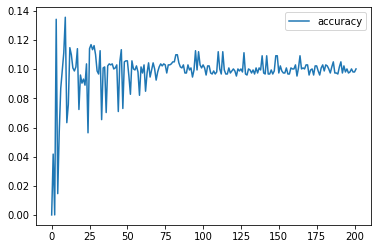

In [534]:
plt.plot(range(202),a,label='accuracy');plt.legend()

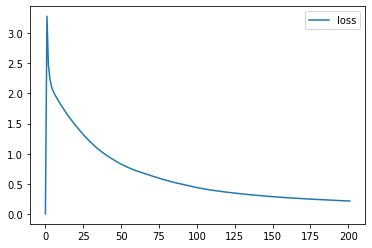

In [535]:
plt.plot(range(202),l,label='loss');plt.legend()